# Web Scraping Job Salaries from Indeed.com. 

## Scraping job listings from Indeed.com

In [1]:
# Import packages 

import requests
import numpy as np
import bs4
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm
import time 
import random
import csv
import datetime
import glob
import re
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pprint
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Sample URL
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=20"

# Request job search results from sample page
r = requests.get(URL)
soup = BeautifulSoup(r.text, 'html.parser')

# Count job search results from sample page
len(soup.find_all('div', class_='job_seen_beacon'))

15

*I've used the inspect tool in Chrome to identify ('table', class_='job_seen_beacon') as the template for each new job produced by an Indeed search. There are 15 jobs per page. There seem to be very few jobs with a salary range.*

In [3]:
# Prettify and review a single job result
prettyHTML = soup.find_all('div', class_='job_seen_beacon')[0].prettify() 
pprint.pprint(prettyHTML)

('<div class="job_seen_beacon">\n'
 ' <table cellpadding="0" cellspacing="0" class="jobCard_mainContent '
 'big6_visualChanges" role="presentation">\n'
 '  <tbody>\n'
 '   <tr>\n'
 '    <td class="resultContent">\n'
 '     <div class="heading4 color-text-primary singleLineTitle '
 'tapItem-gutter">\n'
 '      <h2 class="jobTitle jobTitle-color-purple">\n'
 '       <span title="Data Scientist">\n'
 '        Data Scientist\n'
 '       </span>\n'
 '      </h2>\n'
 '     </div>\n'
 '     <div class="heading6 company_location tapItem-gutter companyInfo">\n'
 '      <span class="companyName">\n'
 '       <a class="turnstileLink companyOverviewLink" '
 'data-tn-element="companyName" href="/cmp/National-Research-Group" '
 'rel="noopener" target="_blank">\n'
 '        National Research Group\n'
 '       </a>\n'
 '      </span>\n'
 '      <span class="ratingsDisplay withRatingLink">\n'
 '       <a aria-label="Company rating 2.3 out of 5 stars" class="ratingLink" '
 'data-tn-variant="cmplinktst2"

## Write functions to extract each items from a job listing

In [4]:
# Save a sample job to test functions on - it's unlikely that this will be well poplated with data
result=soup.find_all('div', class_='job_seen_beacon')[3]

In [5]:
# Extraction function definitions

def extract_location_from_result(result):
    try:
        j_location = result.find('div', attrs={'class':'companyLocation'}).text.strip()
    except:
        j_location = np.nan         
    return j_location

def extract_employer_from_result(result):
    try:
        j_employer = result.find('span', attrs={'class':'companyName'}).text.strip()
    except:
        j_employer = np.nan         
    return j_employer

def extract_title_from_result(result):
    try:
        j_title = result.find('h2', attrs={'class':'jobTitle jobTitle-color-purple'}).text.strip().title()
    except:
        j_title = np.nan         
    return j_title

def extract_salary_from_result(result):
    try:
        j_salary = result.find('div', attrs={'class':'salary-snippet'}).text.strip()
    except:
        j_salary = np.nan         
    return j_salary

def extract_summary_from_result(result):
    try:
        j_summary = result.find('div', attrs={'class':'job-snippet'}).text.strip()
    except:
        j_summary = np.nan         
    return j_summary

def extract_employer_rating_from_result(result):
    try:
        j_employer_rating = result.find('span', attrs={'aria-hidden':True}).text.strip()
    except:
        j_employer_rating = np.nan         
    return j_employer_rating
        

In [6]:
#Print function results from a sample job card 

print('Title:',extract_title_from_result(result))
print('Salary:',extract_salary_from_result(result))
print('Location:',extract_location_from_result(result))
print('Employer:',extract_employer_from_result(result))
print('Employer rating:',extract_employer_rating_from_result(result))
print('Summary:',extract_summary_from_result(result))

Title: Data Scientist
Salary: nan
Location: New York, NY
Employer: CANDY
Employer rating: 4.3
Summary: Translate data insights into product recommendations.
You will play a major role in owning high impact product areas, driving transparency through reporting,…


*Now I have this working for one job, it's time to scale it up.*

## Construct a function to collect results from multiple cities and starting points. 

In [7]:
#Define job scrape function 

def scrape_jobs(scrape_dict):
    """Function designed to scrape jobs from Indeed.com
    
    Takes an input parameter dictionary in the form:
    
    {'num_pages' : 10,
     'roles' : ['data_scientist','data_analyst'],
     'cities' : ['London', 'Bristol'],
     'site' : 'https://www.uk.indeed.com/jobs',
     'currency' : 'GBP'}
     
    """

    #Function takes a scrape dictionary as input to define scrape parameters
    num_pages = scrape_dict['num_pages']*10
    site = scrape_dict['site']
    currency = scrape_dict['currency']

    # Iterate over cities in scrape_dict
    for city in tqdm(scrape_dict['cities']):
        
        # Initialise empty lists to hold results
        results = []
        j_title = []
        j_salary = []
        j_location = []
        j_employer = []
        j_employer_rating = []
        j_summary = []
        search_city = []
        search_role = []
        
        # Iterate over the specified number of pages of search results
        for start in range(0, num_pages, 10):
            
            # Iterate over the specified roles to search for
            for role in scrape_dict['roles']:
                
                # Use f-strings to make the search URL
                url = f'{site}?q={role}&l={city}&start={start}'
                # Slow the scrape down to appear a little human
                time.sleep(random.randint(1,3))
                # Use requests package to return HTML
                r = requests.get(url)
                # Use bs4 to parse the HTML
                soup = BeautifulSoup(r.text, 'html.parser')
                
                # Iterate over the 15 search results on each page
                for i in range(15):
                    
                    # Try and except to absorb errors without failing.
                    try:
                        
                        # Append raw results from job_seen_beacon - redundancy measure
                        results.append(soup.find_all('div', class_='job_seen_beacon')[i])
                        
                        # Append each piece of job data to the initialised list
                        # Uses functions defined perviously
                        smallsoup = soup.find_all('div', class_='job_seen_beacon')[i]
                        j_title.append(extract_title_from_result(smallsoup))
                        j_salary.append(extract_salary_from_result(smallsoup))
                        j_location.append(extract_location_from_result(smallsoup))
                        j_employer.append(extract_employer_from_result(smallsoup))
                        j_employer_rating.append(extract_employer_rating_from_result(smallsoup))
                        j_summary.append(extract_summary_from_result(smallsoup))
                        search_city.append(city)
                        search_role.append(role)
                        
                    except: 
                        pass

        #Outputting df formatted data to csv    
        now = (datetime.datetime.now().strftime("%d%B_%I%M%p"))
        jobs = pd.DataFrame({'title': j_title,
                             'salary': j_salary,
                             'location': j_location,
                             'employer': j_employer,
                             'employer_rating':j_employer_rating,
                             'summary':j_summary,
                             'search_city':search_city,
                             'search_role':search_role})
        filepathdf=f'df/{now}_{city}_{currency}.csv'
        jobs.to_csv(filepathdf, index=False, header=['title','salary','location','employer','employer_rating','summary','search_city', 'search_role'] )

        #Outputting raw scraped data for each city as csv - redundancy measure             
        filepathraw=f'raw/{now}_{city}_{currency}.csv'
        with open(filepathraw,'w', newline='') as f:
            wr = csv.writer(f)
            wr.writerows(results)

In [8]:
#Define input paramaters for job scrape function for different countries 


scrape_uk = {
    'num_pages' : 80,
    'roles' : ['data_scientist','data_analyst'],
    'cities' : ['London', 'Bristol', 'Manchester', 'Leeds', 'Glasgow','Edinburgh', 'Liverpool', 'Oxford', 
              'Cambridge', 'Birmingham', 'Brighton', 'Leicester'],
    'site' : 'https://www.uk.indeed.com/jobs',
    'currency' : 'GBP'}

scrape_us = {
    'num_pages' : 80,
    'roles' : ['data_scientist','data_analyst'],
    'cities' : ['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
                'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
                'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', 'Las+Vegas'],
    'site' : 'https://www.indeed.com/jobs',
    'currency' : 'USD'}

scrape_fr = {
    'num_pages' : 80,
    'roles' : ['data_scientist','data_analyst'],
    'cities' : ['Paris','Marseille','Lyon','Toulouse'],
    'site' : 'https://www.fr.indeed.com/emplois',
    'currency' : 'EUR'}

scrape_de = {
    'num_pages' : 80,
    'roles' : ['data_scientist','data_analyst'],
    'cities' : ['Berlin','Hamburg','Cologne','Munich','Frankfurt','Essen','Dortmund'],
    'site' : 'https://www.de.indeed.com/jobs',
    'currency' : 'EUR'}

scrape_ca = {
    'num_pages' : 80,
    'roles' : ['data_scientist','data_analyst'],
    'cities' : ['Toronto','Montreal','Ottawa','Calgary','Mississauga','Winnipeg','Vancouver'],
    'site' : 'https://www.ca.indeed.com/jobs',
    'currency' : 'CADUSD'}

In [9]:
#Run the scrape function for each country - commented out so I don't run by accident

#scrape_jobs(scrape_us)
#scrape_jobs(scrape_uk)
#scrape_jobs(scrape_fr)
#scrape_jobs(scrape_de)
#scrape_jobs(scrape_ca)

*The data have been scraped and output to csv already. For this notebook we're just going to read in all csvs.*

In [10]:
# Read many many files from /df/ folder.

# US scrape - Use glob to manipulate file names
path = r'/Users/robertdavies/Desktop/DSI/GA_P2/DSI21-lessons/projects/project-4/df' 
all_files = glob.glob(path + "/*_USD.csv")

li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

jobs_us = pd.concat(li, axis=0, ignore_index=True)
jobs_us['country']='US'

# UK scrape
path = r'/Users/robertdavies/Desktop/DSI/GA_P2/DSI21-lessons/projects/project-4/df' 
all_files = glob.glob(path + "/*_GBP.csv")

li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

jobs_uk = pd.concat(li, axis=0, ignore_index=True)
jobs_uk['country']='UK'

# EU scrape
path = r'/Users/robertdavies/Desktop/DSI/GA_P2/DSI21-lessons/projects/project-4/df' # use your path
all_files = glob.glob(path + "/*_EUR.csv")

li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

jobs_eu = pd.concat(li, axis=0, ignore_index=True)
jobs_eu['country']='EU'

# CAN scrape
path = r'/Users/robertdavies/Desktop/DSI/GA_P2/DSI21-lessons/projects/project-4/df' # use your path
all_files = glob.glob(path + "/*_CADUSD.csv")

li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

jobs_ca = pd.concat(li, axis=0, ignore_index=True)
jobs_ca['country']='CA'

In [11]:
# Print shape of df's on input 
print('US jobs df shape after importing all:',jobs_us.shape)
print('UK jobs df shape after importing all:',jobs_uk.shape)
print('EU jobs df shape after importing all:',jobs_eu.shape)
print('CA jobs df shape after importing all:',jobs_ca.shape)

US jobs df shape after importing all: (46394, 9)
UK jobs df shape after importing all: (26993, 9)
EU jobs df shape after importing all: (7750, 9)
CA jobs df shape after importing all: (8628, 9)


*Now, we need to clean up salary data.*

1. *Only a small number of the scraped results have salary information - only these will be used for modeling.*
1. *Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.*
1. *Some of the entries may be duplicated.*
1. *The salaries are given as text and usually with ranges.*

In [12]:
# Print shape of df's through filtering/preprocessing 

# Drop duplicates from each
jobs_us.drop_duplicates(subset=['title','location'], keep='first', inplace=True)
jobs_uk.drop_duplicates(subset=['title','location'], keep='first', inplace=True)
jobs_eu.drop_duplicates(subset=['title','location'], keep='first', inplace=True)
jobs_ca.drop_duplicates(subset=['title','location'], keep='first', inplace=True)

print('US jobs df shape after dropping duplicates',jobs_us.shape)
print('UK jobs df shape after dropping duplicates',jobs_uk.shape)
print('EU jobs df shape after dropping duplicates',jobs_eu.shape)
print('CA jobs df shape after dropping duplicates',jobs_eu.shape)

# Drop jobs with NaN salary
jobs_us.dropna(subset=['salary'], inplace=True)
jobs_uk.dropna(subset=['salary'], inplace=True)
jobs_eu.dropna(subset=['salary'], inplace=True)
jobs_ca.dropna(subset=['salary'], inplace=True)

print('US jobs df shape after dropping missing salaries',jobs_us.shape)
print('UK jobs df shape after dropping missing salaries',jobs_uk.shape)
print('EU jobs df shape after dropping missing salaries',jobs_eu.shape)
print('CA jobs df shape after dropping missing salaries',jobs_ca.shape)

# Initially I was going to only retain annual salaries, but I decided to keep all and salvage them
# jobs_us= jobs_us[jobs_us['salary'].str.contains('year')].copy()
# jobs_uk= jobs_uk[jobs_uk['salary'].str.contains('year')].copy()
# jobs_eu= jobs_eu[jobs_eu['salary'].str.contains('year')].copy()
# jobs_ca= jobs_ca[jobs_ca['salary'].str.contains('year')].copy()

US jobs df shape after dropping duplicates (10543, 9)
UK jobs df shape after dropping duplicates (3671, 9)
EU jobs df shape after dropping duplicates (2157, 9)
CA jobs df shape after dropping duplicates (2157, 9)
US jobs df shape after dropping missing salaries (421, 9)
UK jobs df shape after dropping missing salaries (1340, 9)
EU jobs df shape after dropping missing salaries (148, 9)
CA jobs df shape after dropping missing salaries (232, 9)


## Define functions to assist in data cleaning


*We now define some functions to be used in data cleaning. These will be used to clean and convert all salaries to annual salaries in GBP*

In [13]:
# Function definitions. Currency conversions are lazy but work 

def salary_tidy(x):
    """Function designed to format the salary column"""
    #Step1 - replace unwanted charcaters
    replace_chars = '$,.£&€'
    for char in replace_chars:
        x=x.replace(char,'')
    
    if ('day' or 'journée' or 'tag') in x.lower():
        #Step2 - filter to retain all consecutive digits in a list
        x = re.findall('[0-9]+',x)     
        #Step3 - Return salary or average salary
        if len(x)==1:
            salary = int(x[0])
            salary = salary*260
        elif len(x)==2:
            salary = (int(x[0])+int(x[1]))/2
            salary = salary*260
        else:
            raise ValueError("The salary must have either one or two terms")
    elif ('week' or 'woche' or 'smeaine') in x.lower():
        #Step2 - filter to retain all consecutive digits in a list
        x = re.findall('[0-9]+',x)     
        #Step3 - Return salary or average salary
        if len(x)==1:
            salary = int(x[0])
            salary = salary*52
        elif len(x)==2:
            salary = (int(x[0])+int(x[1]))/2
            salary = salary*52
        else:
            raise ValueError("The salary must have either one or two terms")
    elif ('month' or 'monat' or 'mois') in x.lower():
        #Step2 - filter to retain all consecutive digits in a list
        x = re.findall('[0-9]+',x)     
        #Step3 - Return salary or average salary
        if len(x)==1:
            salary = int(x[0])
            salary = salary*12
        elif len(x)==2:
            salary = (int(x[0])+int(x[1]))/2
            salary=salary*12
        else:
            raise ValueError("The salary must have either one or two terms")
    else:
        #Step2 - filter to retain all consecutive digits in a list
        x = re.findall('[0-9]+',x)     
        #Step3 - Return salary or average salary
        if len(x)==1:
            salary = int(x[0])
        elif len(x)==2:
            salary = (int(x[0])+int(x[1]))/2
        else:
            raise ValueError("The salary must have either one or two terms")
    return salary

def replace_non_ascii(text, replace_char):
    return re.sub(r'[^\x00-\x7F]+', replace_char, text)

def convert_USD_to_GBP(x):
    return x*0.74

def convert_EUR_to_GBP(x):
    return x*0.84

def convert_CADUSD_to_GBP(x):
    return x*0.58

In [14]:
# Clean salary columns for each of the jobs_country dataframes 

# Apply cleaning functions
jobs_us.salary = jobs_us.salary.apply(lambda x: salary_tidy(x))
jobs_us.salary = jobs_us.salary.apply(lambda x: convert_USD_to_GBP(x))
jobs_uk.salary = jobs_uk.salary.apply(lambda x: salary_tidy(x))
jobs_eu.salary = jobs_eu.salary.apply(lambda x: replace_non_ascii(x,''))
jobs_eu.salary = jobs_eu.salary.apply(lambda x: salary_tidy(x))
jobs_eu.salary = jobs_eu.salary.apply(lambda x: convert_EUR_to_GBP(x))
jobs_ca.salary = jobs_ca.salary.apply(lambda x: salary_tidy(x))
jobs_ca.salary = jobs_ca.salary.apply(lambda x: convert_USD_to_GBP(x))

# Concatenate dataframes
jobs = pd.concat([jobs_uk,jobs_us,jobs_eu, jobs_ca], axis=0, ignore_index=True)

In [15]:
#Evaluate shape after cleaning dataframes and print 

print('US jobs df shape after salary cleaning',jobs_us.shape)
print('UK jobs df shape after salary cleaning',jobs_uk.shape)
print('EU jobs df shape after salary cleaning',jobs_eu.shape)
print('CA jobs df shape after salary cleaning',jobs_ca.shape)
print('Joint jobs df shape after salary cleaning and cat',jobs.shape)

US jobs df shape after salary cleaning (421, 9)
UK jobs df shape after salary cleaning (1340, 9)
EU jobs df shape after salary cleaning (148, 9)
CA jobs df shape after salary cleaning (232, 9)
Joint jobs df shape after salary cleaning and cat (2141, 9)


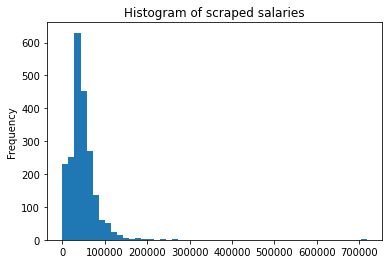

In [16]:
#Plot quick histogram of salaries 
jobs.salary.plot(kind='hist', bins=50,title='Histogram of scraped salaries');

## Write clean results to CSV

In [17]:
jobs.to_csv(r'C:\Users\Admin\DataScienceProjects\SQL_Projects\HR-Job-Salary-Analysis-using-SQL-Power-BI\web_scraped_data.csv', index=False, header=jobs.columns )

## Read in the cleaned jobs CSV

In [18]:
jobs = pd.read_csv(r'C:\Users\Admin\DataScienceProjects\SQL_Projects\HR-Job-Salary-Analysis-using-SQL-Power-BI\web_scraped_data.csv', index_col=None, header=0)

# A little further cleaning to remove spaces in data
jobs['search_role']=[x.replace(' ','_') for x in jobs['search_role']]

## High level EDA

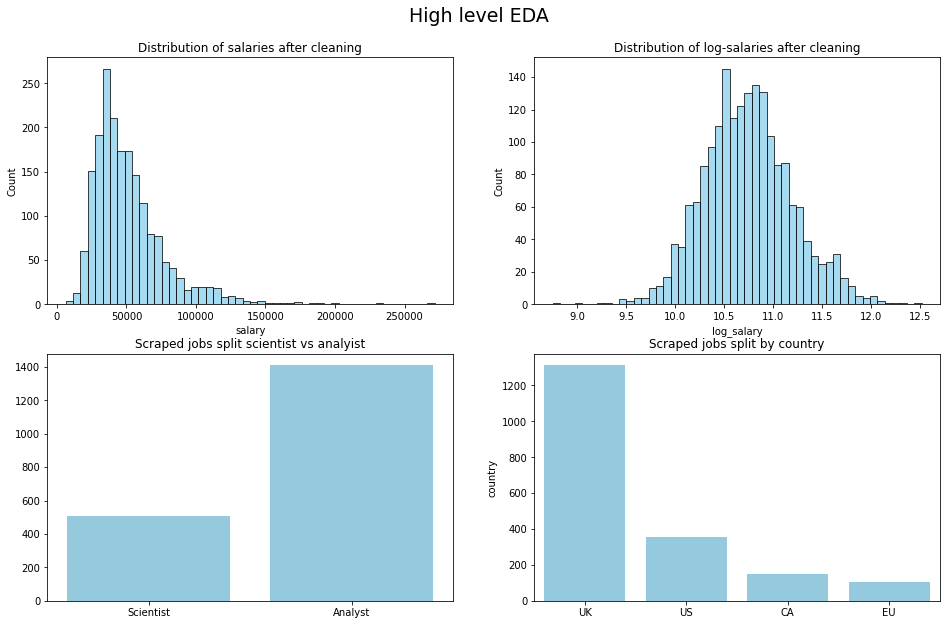

In [24]:
# High level EDA plot for the report! This is the data going into modeling.
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,10))
sns.histplot(data = jobs.log_salary, ax=ax[0,1], bins=50,color='skyblue')
sns.histplot(data = jobs.salary, ax=ax[0,0], bins=50,color='skyblue')
sns.barplot(x=['Scientist','Analyst'], y=[jobs.search_role.value_counts()[1],jobs.search_role.value_counts()[0]], ax=ax[1,0],color='skyblue')
sns.barplot(x=pd.DataFrame(jobs.country.value_counts()).index, y=pd.DataFrame(jobs.country.value_counts()).country, ax=ax[1,1],color='skyblue')
ax[0,0].set_title('Distribution of salaries after cleaning')
ax[0,1].set_title('Distribution of log-salaries after cleaning')
ax[1,0].set_title('Scraped jobs split scientist vs analyist')
ax[1,1].set_title('Scraped jobs split by country')
plt.suptitle('High level EDA', fontsize=19, y=0.95)
plt.show()

*This concludes the Jupyter Notebook. Most of this has been included in the readme file for this project.*